# 0. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset, Dataset
from scipy.sparse import csr_matrix
from abc import ABC, abstractmethod

import warnings
warnings.filterwarnings("ignore")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
ML_PATH = "ml-1m"
USERS_PATH = ML_PATH + "/users.dat"
MOVIES_PATH = ML_PATH + "/movies.dat"
RATINGS_PATH = ML_PATH + "/ratings.dat"

# 1. Load Data

In [3]:
users_df = pd.read_csv(USERS_PATH, sep="::", names=['userId', 'gender', 'ageCode', 'occupationCode', 'zipCode'])
age_code_mapping = {1:  "Under 18", 18:  "18-24", 25:  "25-34", 35:  "35-44", 45:  "45-49", 50:  "50-55", 56:  "56+"}
users_df['age'] = users_df['ageCode'].map(age_code_mapping)
occupation_code_mapping = {
    0:  "other",
	1:  "academic/educator",
	2:  "artist",
	3:  "clerical/admin",
	4:  "college/grad student",
	5:  "customer service",
	6:  "doctor/health care",
	7:  "executive/managerial",
	8:  "farmer",
	9:  "homemaker",
	10:  "K-12 student",
	11:  "lawyer",
	12:  "programmer",
	13:  "retired",
	14:  "sales/marketing",
	15:  "scientist",
	16:  "self-employed",
	17:  "technician/engineer",
	18:  "tradesman/craftsman",
	19:  "unemployed",
	20:  "writer"
}
users_df['occupation'] = users_df['occupationCode'].map(occupation_code_mapping)
users_df.head()

,userId,gender,ageCode,occupationCode,zipCode,age,occupation
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


In [4]:
movies_df = pd.read_csv(MOVIES_PATH, sep="::", names=['movieId', 'title', 'genres'], encoding='latin-1')
movies_genre_df = movies_df.copy()
movies_genre_df['genres'] = movies_genre_df['genres'].map(lambda x: x.split("|"))
movies_genre_df = movies_genre_df.explode('genres')
display(movies_df.head())
display(movies_genre_df.head())

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


,movieId,title,genres
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children's
0,1,Toy Story (1995),Comedy
1,2,Jumanji (1995),Adventure
1,2,Jumanji (1995),Children's


In [5]:
ratings_df = pd.read_csv(RATINGS_PATH, sep="::", names=['userId', 'movieId', 'rating', 'timestamp'])
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# 2. Evaluation Split

## 2.A. Random

In [6]:
def random_split(df, user_id_col, movie_id_col, holdout_fraction=0.2):
    test = df.sample(frac=holdout_fraction, replace=False, random_state=42)
    train = df[~df.index.isin(test.index)]
    users_train = train[user_id_col].unique()
    movies_train = train[movie_id_col].unique()
    train_users_count = len(users_train)
    train_movies_count = len(movies_train)
    test_users_count = len(test[user_id_col].unique())
    test_movies_count = len(test[movie_id_col].unique())
    print(f"Train count: {len(train)}")
    print(f"Train users count: {train_users_count}")
    print(f"Train movies count: {train_movies_count}")
    print(f"Test count: {len(test)}")
    print(f"Test users count: {test_users_count}")
    print(f"Test movies count: {test_movies_count}")

    users_train = train[user_id_col].unique()
    movies_train = train[movie_id_col].unique()
    test = test[(test[user_id_col].isin(users_train)) & (test[movie_id_col].isin(movies_train))]
    print("Truncating test users & items invalid for CF completed.")
    print(f"Test count: {len(test)}")
    test_users_count_after = len(test[user_id_col].unique())
    test_movies_count_after = len(test[movie_id_col].unique())
    print(f"Test users count: {test_users_count_after}")
    print(f"{(1- (test_users_count_after/test_users_count))*100:.4f}% of users truncated.")
    print(f"Test movies count: {test_movies_count_after}")
    print(f"{(1- (test_movies_count_after/test_movies_count))*100:.4f}% of movies truncated.")
    return train, test

In [7]:
rnd_train_df, rnd_test_df = random_split(ratings_df, user_id_col='userId', movie_id_col='movieId', holdout_fraction=0.1)

Train count: 900188
Train users count: 6040
Train movies count: 3694
Test count: 100021
Test users count: 5970
Test movies count: 3294
Truncating test users & items invalid for CF completed.
Test count: 100009
Test users count: 5970
0.0000% of users truncated.
Test movies count: 3282
0.3643% of movies truncated.


## 2.B. Leave-One-Out

In [8]:
def leave_one_out_split(df, user_id_col, movie_id_col, holdout_fraction=0.2):
    df['rank'] = df.sort_values(['timestamp'], ascending=True) \
             .groupby(['userId']) \
             .cumcount() + 1
    test = df[df['rank'] == 1]
    train = df[df['rank'] > 1]
    movies_train = train[movie_id_col].unique()
    train_users_count = len(train[user_id_col].unique())
    train_movies_count = len(movies_train)
    test_users_count = len(test[user_id_col].unique())
    test_movies_count = len(test[movie_id_col].unique())
    print(f"Train count: {len(train)}")
    print(f"Train users count: {train_users_count}")
    print(f"Train movies count: {train_movies_count}")
    print(f"Test count: {len(test)}")
    print(f"Test users count: {test_users_count}")
    print(f"Test movies count: {test_movies_count}")
    
    test = test[(test[movie_id_col].isin(movies_train))]
    print("Truncating test items invalid for CF completed.")
    test_movies_count_after = len(test[movie_id_col].unique())
    print(f"Test movies count: {test_movies_count_after}")
    print(f"{(1- (test_movies_count_after/test_movies_count))*100:.4f}% of movies truncated.")
    return train, test

In [9]:
loo_train_df, loo_test_df = leave_one_out_split(ratings_df, user_id_col='userId', movie_id_col='movieId', holdout_fraction=0.1)

Train count: 994169
Train users count: 6040
Train movies count: 3702
Test count: 6040
Test users count: 6040
Test movies count: 1684
Truncating test items invalid for CF completed.
Test movies count: 1680
0.2375% of movies truncated.


## 2.C. Global Temporal

In [10]:
def global_temporal_split(df, timestamp_col, user_id_col, movie_id_col, holdout_fraction=0.2):
    cutoff_date = df[timestamp_col].quantile(q=1-holdout_fraction)
    test = df[df[timestamp_col] > cutoff_date]
    train = df[df[timestamp_col] <= cutoff_date]
    users_train = train[user_id_col].unique()
    movies_train = train[movie_id_col].unique()
    train_users_count = len(users_train)
    train_movies_count = len(movies_train)
    test_users_count = len(test[user_id_col].unique())
    test_movies_count = len(test[movie_id_col].unique())
    print("Split completed.")
    print(f"Train count: {len(train)}")
    print(f"Train users count: {train_users_count}")
    print(f"Train movies count: {train_movies_count}")
    print(f"Test count: {len(test)}")
    print(f"Test users count: {test_users_count}")
    print(f"Test movies count: {test_movies_count}")
    
    # make sure all users in test are in train
    users_train = train[user_id_col].unique()
    movies_train = train[movie_id_col].unique()
    test = test[(test[user_id_col].isin(users_train)) & (test[movie_id_col].isin(movies_train))]
    print("Truncating test users & items invalid for CF completed.")
    print(f"Test count: {len(test)}")
    test_users_count_after = len(test[user_id_col].unique())
    test_movies_count_after = len(test[movie_id_col].unique())
    print(f"Test users count: {test_users_count_after}")
    print(f"{(1- (test_users_count_after/test_users_count))*100:.4f}% of users truncated.")
    print(f"Test movies count: {test_movies_count_after}")
    print(f"{(1- (test_movies_count_after/test_movies_count))*100:.4f}% of movies truncated.")
    return train, test

In [11]:
gts_train_df, gts_test_df = global_temporal_split(ratings_df, timestamp_col='timestamp', user_id_col = 'userId', movie_id_col='movieId', holdout_fraction=0.1)

Split completed.
Train count: 900188
Train users count: 6011
Train movies count: 3678
Test count: 100021
Test users count: 1209
Test movies count: 3407
Truncating test users & items invalid for CF completed.
Test count: 95723
Test users count: 1179
2.4814% of users truncated.
Test movies count: 3377
0.8805% of movies truncated.


# Prep Dataset

In [12]:
def create_valid_idx(train_df, test_df):
    user_idx_mapping = {original_id: i for i, original_id in enumerate(train_df['userId'].unique())}
    movie_idx_mapping = {original_id: i for i, original_id in enumerate(train_df['movieId'].unique())}
    train_df['userId_idx'] = train_df['userId'].map(user_idx_mapping)
    test_df['userId_idx'] = test_df['userId'].map(user_idx_mapping)
    train_df['movieId_idx'] = train_df['movieId'].map(movie_idx_mapping)
    test_df['movieId_idx'] = test_df['movieId'].map(movie_idx_mapping)
    return train_df, test_df

In [13]:
gts_train_df, gts_test_df = create_valid_idx(gts_train_df, gts_test_df)
loo_train_df, loo_test_df = create_valid_idx(loo_train_df, loo_test_df)
rnd_train_df, rnd_test_df = create_valid_idx(rnd_train_df, rnd_test_df)

# 3. Defining Models

In [ ]:
class PRDataset(Dataset):
    def __init__(self, user_ids, item_ids, user_liked_train, all_itemIds, n_items):
        self.user_ids = torch.tensor(user_ids, dtype=torch.long)
        self.item_ids = torch.tensor(item_ids, dtype=torch.long)
        self.user_liked_train = user_liked_train
        self.all_itemIds = all_itemIds
        self.n_items = n_items
    
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, index):
        curr_userId = self.user_ids[index]
        curr_pos_itemId = self.item_ids[index]
        user_liked_items = self.user_liked_train[int(curr_userId)]
        while True:
            user_neg_item = np.random.randint(0, self.n_items)
            if user_neg_item not in user_liked_items:
                break
        
        return (curr_userId, curr_pos_itemId, torch.tensor(user_neg_item, dtype=torch.long))

In [ ]:
class DataPreparation:
    def __init__(self, train_df, test_df, user_col_ori, item_col_ori, rating_col, implicit, threshold):
        self.train_df = train_df.copy()
        self.test_df = test_df.copy()
        self.user_col_ori = user_col_ori
        self.item_col_ori = item_col_ori
        self.rating_col = rating_col
        self.implicit = implicit
        self.threshold = threshold
        if implicit:
            self._convert_df_to_implicit()
        
        self.n_users = train_df[user_col_ori].nunique()
        self.n_items = train_df[item_col_ori].nunique()
        self.train_user_ids = list(train_df[user_col_ori].unique())
        self.train_item_ids = list(train_df[item_col_ori].unique())
        self.test_user_ids = list(test_df[user_col_ori].unique())
        self.test_item_ids = list(test_df[item_col_ori].unique())
        
        self.set_userId_sequenced_map()
        self.set_itemId_sequenced_map()
        
        self.item_user_matrix = self._build_item_user_train_occurence_matrix()
        self.user_seen_map = self._build_user_seen_map()
        self.user_ground_truth = self._build_user_ground_truth()
        self.user_liked_train = self._build_user_liked_train()
    
    def _convert_df_to_implicit(self):
        """Convert dataframe from 5-star rating to implicit signals
        """
        if self.implicit:
            self.train_df[self.rating_col] = self.train_df[self.rating_col].map(lambda x: 1 if x >= self.threshold else 0)
            self.test_df[self.rating_col] = self.test_df[self.rating_col].map(lambda x: 1 if x >= self.threshold else 0)
        else:
            pass
    
    def set_userId_sequenced_map(self):
        """set a dictionary of {original userId: transformed userId}
        """
        self.userId_map = {original_id: i for i, original_id in enumerate(self.train_user_ids)}
        self.userId_map_rev = {v: k for k, v in self.userId_map.items()}
    
    def set_itemId_sequenced_map(self):
        """set a dictionary of {original itemId: transformed itemId}
        """
        self.itemId_map = {original_id: i for i, original_id in enumerate(self.train_item_ids)}
        self.itemId_map_rev = {v: k for k, v in self.itemId_map.items()}
        
    def _build_item_user_train_occurence_matrix(self):
        """get sparse matrix of item-user interaction in train set with n_rows = n_items and n_cols = n_users
        Return: csr_matrix
        """
        item_user_matrix = csr_matrix(
            (np.ones(len(self.train_df)), 
             ([self.itemId_map[i] for i in self.train_df[self.item_col_ori].values], 
              [self.userId_map[u] for u in self.train_df[self.user_col_ori].values])
            ), 
            shape=(self.n_items, self.n_users)
        )
        
        return item_user_matrix
    
    def _build_user_seen_map(self):
        """Get a dictionary map of {user: set of itemIds the user interacted with in train set}
        Return: dict
        """
        user_seen_map = self.train_df.groupby(self.user_col_ori)[self.item_col_ori].apply(set).to_dict()
        
        return user_seen_map
    
    def _build_user_ground_truth(self):
        """Get a dictionary map of {user: itemIds that are liked by user in test set}
        Return: dict
        """
        
        # Filter out disliked items
        if self.implicit:
            liked_df = self.test_df[self.test_df[self.rating_col] == 1.0]
        else:
            liked_df = self.test_df[self.test_df[self.rating_col] >= self.threshold]
        
        user_ground_truth = liked_df.groupby(self.user_col_ori)[self.item_col_ori].apply(set).to_dict()
        
        return user_ground_truth
    
    def _build_user_liked_train(self):
        """Get a dictionary map of {user: itemIds that are liked by user in train set}
        Return: dict
        """
        
        # Filter out disliked items
        if self.implicit:
            liked_df = self.train_df[self.train_df[self.rating_col] == 1.0]
        else:
            liked_df = self.train_df[self.train_df[self.rating_col] >= self.threshold]
        
        user_liked_train = liked_df.groupby(self.user_col_ori)[self.item_col_ori].apply(set).to_dict()
        
        return user_liked_train
    
    def create_dataloader(self, set_type, batch_size: int, shuffle: bool) -> DataLoader:
        """Helper to create PyTorch DataLoader."""
        if set_type == "train":
            df = self.train_df
        else:
            df = self.test_df
        
        user_ids = torch.tensor([self.userId_map[u] for u in df[self.user_col_ori].values], dtype=torch.long)
        item_ids = torch.tensor([self.itemId_map[i] for i in df[self.item_col_ori].values], dtype=torch.long)
        ratings = torch.tensor(df[self.rating_col].values, dtype=float)
        
        dataset = TensorDataset(user_ids, item_ids, ratings)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    def create_pr_dataloader(self, batch_size: int, shuffle: bool) -> DataLoader:
        df = self.train_df
            
        if self.implicit:
            liked_df = df[df[self.rating_col] == 1.0]
        else:
            liked_df = df[df[self.rating_col] >= self.threshold]
        
        user_ids = [self.userId_map[u] for u in liked_df[self.user_col_ori].values]
        liked_item_ids = [self.itemId_map[i] for i in liked_df[self.item_col_ori].values]
        
        all_item_ids = set([self.itemId_map[i] for i in self.train_item_ids])
        user_liked_train = {
            self.userId_map[u]: {self.itemId_map[i] for i in items}
            for u, items in self.user_liked_train.items()
        }
        
        dataset = PRDataset(user_ids, liked_item_ids, user_liked_train, all_item_ids, self.n_items)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
class BaseRecommender(ABC):
    @abstractmethod
    def fit(self):
        pass
    @abstractmethod
    def recommend_all(self, k):
        pass
    @abstractmethod
    def recommend_for_user(self, userId, k):
        pass

In [ ]:
def prhn_at_k(ranked_list: list, user_actuals: list, k=10):
    user_actuals_set = set(user_actuals)
    if not user_actuals_set:
        return [], set()
    top_k_items = ranked_list[:k]
    true_positives = [(rank, item) for rank, item in enumerate(top_k_items) 
                      if item in user_actuals_set]
    
    precision = len(true_positives) / k
    recall = len(true_positives) / len(user_actuals_set)
    hit = 1.0 if len(true_positives) > 0 else 0.0
    dcg = sum(1.0 / np.log2(rank + 2) for rank, item in true_positives)
    num_possible = min(k, len(user_actuals_set))
    idcg = sum(1.0 / np.log2(i + 2) for i in range(num_possible))
    ndcg = dcg / idcg if idcg > 0 else 0.0
    
    return precision, recall, hit, ndcg

In [ ]:
def prhn_evaluator(model, all_liked_items, user_seen_map, train_df, test_df, k=10, implicit=False):
    all_userIds = set(test_df['userId_idx'])
    all_itemIds = set(train_df['movieId_idx'])
    
    precisions, recalls, hits, ndcgs = 0, 0, 0, 0
    
    all_recommendations = model.recommend_all(all_userIds, all_itemIds, user_seen_map, k)
    for u in all_userIds:
        user_predictions = all_recommendations[u]
        user_actuals = all_liked_items[u]
        p, r, h, n = prhn_at_k(user_predictions, user_actuals, k)
        precisions += p
        recalls += r
        hits += h
        ndcgs += n
        
    num_users = len(all_userIds)
    return precisions/num_users, recalls/num_users, hits/num_users, ndcgs/num_users

In [ ]:
class Evaluator:
    def __init__(self, dataprep):
        self.dataprep = dataprep
        self.user_seen_map = dataprep.user_seen_map
        self.user_ground_truth = dataprep.user_ground_truth
        
    def _prepare_evaluation(self, ranked_list: list, user_actuals: list, k:int):
        user_actuals_set = set(user_actuals)
        if not user_actuals_set:
            return [], set()
        top_k_items = ranked_list[:k]
        true_positives = [(rank, item) for rank, item in enumerate(top_k_items) 
                        if item in user_actuals_set]
        return true_positives, user_actuals_set
    
    def _precision_at_k(self, true_positives, user_actuals_set=None, k=None):
        return len(true_positives)/k
    
    def _recall_at_k(self, true_positives, user_actuals_set, k=None):
        return len(true_positives) / len(user_actuals_set)
    
    def _hit_at_k(self, true_positives, user_actuals_set=None, k=None):
        return 1.0 if len(true_positives) > 0 else 0.0
    
    def _ndcg_at_k(self, true_positives, user_actuals_set, k):
        dcg = sum(1.0 / np.log2(rank + 2) for rank, item in true_positives)
        num_possible = min(k, len(user_actuals_set))
        idcg = sum(1.0 / np.log2(i + 2) for i in range(num_possible))
        ndcg = dcg / idcg if idcg > 0 else 0.0
        
        return ndcg
        
    def evaluate(self, recommender, metrics=None, k=10):
        if metrics is None:
            metrics = ['precision', 'recall', 'hit', 'ndcg']
        
        test_userIds = set(self.dataprep.test_user_ids)
        train_itemIds = set(self.dataprep.train_item_ids)
        
        all_recommendations = recommender.recommend_all(k)
        
        metric_functions = {
            'precision': self._precision_at_k,
            'recall': self._recall_at_k,
            'hit': self._hit_at_k,
            'ndcg': self._ndcg_at_k
        }
        
        results = {f'{metric}@{k}': [] for metric in metrics}
        
        for u in test_userIds:
            
            user_predictions = all_recommendations[u]
            user_actuals = self.user_ground_truth[u]
            
            true_positives, user_actuals_set = self._prepare_evaluation(user_predictions, user_actuals, k)
            
            for metric in metrics:
                if metric in metric_functions:
                    score = metric_functions[metric](true_positives, user_actuals_set, k)
                    results[f'{metric}@{k}'].append(score)
            
        return {name: np.mean(scores) for name, scores in results.items()}
        

In [20]:
class BPRLoss(nn.Module):
    """
    Bayesian Personalized Ranking Loss.
    Optimizes: user should prefer positive item over negative item.
    """
    def __init__(self):
        super().__init__()
    
    def forward(self, pos_scores, neg_scores):
        """
        Args:
            pos_scores: Predictions for positive items
            neg_scores: Predictions for negative items
        
        Returns:
            BPR loss value
        """
        return -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-10))

In [ ]:
class PyTorchTrainer:
    def __init__(self, training_configs, device, evaluator):
        self.training_configs = training_configs
        self.device = device
        self.evaluator = evaluator
        self.history = None
    
    def train(self, model, train_loader, test_loader, recommender=None):
        batch_size = self.training_configs['batch_size']
        num_epochs = self.training_configs['num_epochs']
        criterion = self.training_configs['criterion']
        optimizer = self.training_configs['optimizer']
        
        train_loss_list = []
        if isinstance(criterion, BPRLoss):
            test_ndcg_list = []
            self.history = {'train_loss': [], 'test_ndcg': []}
        else:
            test_loss_list = []
            self.history = {'train_loss': [], 'test_loss': []}
            
        model.to(self.device)
        
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            test_total_loss = 0
            
            for batch in train_loader:
                if isinstance(criterion, BPRLoss):
                    user_ids, pos_item_ids, neg_item_ids = batch
                    user_ids = user_ids.to(self.device)
                    pos_item_ids = pos_item_ids.to(self.device)
                    neg_item_ids = neg_item_ids.to(self.device)
                    
                    pos_pred = model(user_ids, pos_item_ids)
                    neg_pred = model(user_ids, neg_item_ids)
                    
                    loss = criterion(pos_pred, neg_pred)
                else:
                    user_ids, item_ids, ratings = batch
                    user_ids = user_ids.to(self.device)
                    item_ids = item_ids.to(self.device)
                    ratings = ratings.to(self.device).float()
                    
                    predictions = model(user_ids, item_ids)
                    loss = criterion(predictions, ratings)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            train_loss = total_loss / len(train_loader)
            
            if isinstance(criterion, BPRLoss):
                train_loss_list.append(train_loss)
            else:
                train_loss_list.append(np.sqrt(train_loss))
        
            if isinstance(criterion, BPRLoss):
                if recommender is None:
                    raise ValueError("recommender must be passed for implicit training")
                test_ndcg = self.evaluator.evaluate(recommender, ['ndcg'], k=10)['ndcg@10']

                test_ndcg_list.append(test_ndcg)
            else:
                model.eval()
                with torch.no_grad():
                    for batch in test_loader:
                        user_id, item_id, rating = batch
                        user_id = user_id.to(self.device)
                        item_id = item_id.to(self.device)
                        rating = rating.to(self.device).float()
                        
                        prediction = model(user_id, item_id)
                        loss = criterion(prediction, rating)
                        test_total_loss += loss.item()
                
                test_loss = test_total_loss / len(test_loader)
                test_loss_list.append(np.sqrt(test_loss))
                
            if isinstance(criterion, BPRLoss):
                print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, '
                      f'Test NDCG: {test_ndcg:.4f}')
            else:
                print(f'Epoch {epoch+1}, Train Loss: {np.sqrt(train_loss):.4f}, '
                      f'Test Loss: {np.sqrt(test_loss):.4f}')
        
        if isinstance(criterion, BPRLoss):
            self.history = {'train_loss': train_loss_list, 'test_ndcg': test_ndcg_list}
        else:
            self.history = {'train_loss': train_loss_list, 'test_loss': test_loss_list}
            
        self._plot_train_test()
        
        return model, self.history
    
    def _plot_train_test(self):
        plt.figure(figsize=(12, 4))
    
        plt.subplot(1, 2, 1)
        for key, value in self.history.items():
            plt.plot(self.history[key], label=key)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Plot')
        plt.legend()
        
        plt.show()

In [21]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        user_matrix = self.user_embedding(user_id)
        item_matrix = self.item_embedding(item_id)
        user_bias = self.user_bias(user_id)
        item_bias = self.item_bias(item_id)
        output = (user_matrix * item_matrix).sum(dim=1) + user_bias.squeeze() + item_bias.squeeze()
        return output

In [ ]:
class MFRecommender(BaseRecommender):
    def __init__(self, dataprep, model, trainer, evaluator
                 ):
        self.dataprep = dataprep
        self.model = model
        self.trainer = trainer
        self.evaluator = evaluator
        self.history = None
        
    def fit(self):        
        if not self.dataprep.implicit:
            train_loader = self.dataprep.create_dataloader("train", self.trainer.training_configs['batch_size'], True)
            test_loader = self.dataprep.create_dataloader("test", self.trainer.training_configs['batch_size'], False)
            self.model, self.history = self.trainer.train(self.model, train_loader, test_loader, recommender=None)
        else:
            train_loader = self.dataprep.create_pr_dataloader(self.trainer.training_configs['batch_size'], True)
            test_loader = self.dataprep.create_dataloader("test", self.trainer.training_configs['batch_size'], False)
            self.model, self.history = self.trainer.train(self.model, train_loader, test_loader, recommender=self)
            
        return self.model, self.history
    
    def recommend_for_user(self, userId, k):
        """Returns top k items and predicted scores for a user
        
        Keyword arguments:
        userId -- original user id
        k -- number of items recommended
        Return: dataframe of top k item id and its predicted score for a user
        """
        
        # Get the sequenced user id used for training embeddings
        userId_idx = self.dataprep.userId_map[userId]
        # Filter out items a user has seen
        unseen_item_ids = list(set(self.dataprep.train_item_ids) - set(self.dataprep.user_seen_map[userId]))
        # Map into item ids used for training
        unseen_item_idx = [self.dataprep.itemId_map[i] for i in unseen_item_ids]
        userId_idx_tensor = torch.tensor([userId_idx], dtype=torch.long, device=self.trainer.device)
        unseen_item_idx_tensor = torch.tensor(unseen_item_idx, dtype=torch.long, device=self.trainer.device)
        
        self.model.eval()
        with torch.no_grad():
            user_embedding = self.model.user_embedding(userId_idx_tensor)
            item_embedding = self.model.item_embedding(unseen_item_idx_tensor)
            user_bias = self.model.user_bias(userId_idx_tensor).view(-1, 1)
            item_bias = self.model.item_bias(unseen_item_idx_tensor).view(1, -1)
            
            user_item_vector = torch.matmul(user_embedding, item_embedding.t()) + user_bias + item_bias
            scores = user_item_vector.squeeze(0)
            scores = scores.detach().cpu().numpy()
            
        top_k_rows = np.argsort(-scores)[:k]
        # Map back to item ids used for training
        top_k_ids = [unseen_item_idx[i] for i in top_k_rows]
        # Map back to original item ids
        top_k_ids = [self.dataprep.itemId_map_rev[a] for a in top_k_ids]
        final_recommendations = {}
        final_recommendations["id"] = top_k_ids
        if self.dataprep.implicit:
            return pd.DataFrame(final_recommendations)
        else:
            top_k_scores = scores[top_k_rows]
            final_recommendations["score"] = top_k_scores
            return pd.DataFrame(final_recommendations)
    
    def recommend_all(self, k):
        test_userIds = self.dataprep.test_user_ids
        train_itemIds = self.dataprep.train_item_ids
        
        test_user_idx = [self.dataprep.userId_map[u] for u in test_userIds]
        train_item_idx = [self.dataprep.itemId_map[i] for i in train_itemIds]

        user_tensor = torch.tensor(test_user_idx, dtype=torch.long, device=self.trainer.device)
        item_tensor = torch.tensor(train_item_idx, dtype=torch.long, device=self.trainer.device)

        self.model.eval()
        with torch.no_grad():
            user_embedding = self.model.user_embedding(user_tensor)
            item_embedding = self.model.item_embedding(item_tensor)
            user_bias = self.model.user_bias(user_tensor).view(-1, 1)
            item_bias = self.model.item_bias(item_tensor).view(1, -1)

            scores = (user_embedding @ item_embedding.T + user_bias + item_bias).cpu().numpy()

        final_recommendations = {}
        for idx, u in enumerate(test_user_idx):
            test_userId = self.dataprep.userId_map_rev[u]
            seen_itemIds = self.dataprep.user_seen_map[test_userId]
            seen_item_idx = [self.dataprep.itemId_map[i] for i in seen_itemIds]
            seen_item_cols = [idx for idx, i in enumerate(train_item_idx) if i in seen_item_idx]
            scores[idx][seen_item_cols] = -np.inf

            top_k_cols = np.argsort(-scores[idx])[:k]
            top_k_idx = [train_item_idx[i] for i in top_k_cols]
            top_k_ids = [self.dataprep.itemId_map_rev[i] for i in top_k_idx]
            final_recommendations[test_userId] = top_k_ids

        return final_recommendations

## 3.E. Item-KNN

In [ ]:
class ItemKNN(BaseRecommender):
    def __init__(self, k_neighbors: int, regularization: int, dataprep):
        self.k_neighbors = k_neighbors
        self.regularization = regularization
        self.dataprep = dataprep
        self.model = None
        
    def fit(self):
        item_user_matrix = self.dataprep.item_user_matrix

        co_counts = item_user_matrix.dot(item_user_matrix.T)
    
        item_counts = co_counts.diagonal()
        sqrt_counts = np.sqrt(item_counts)
        
        co_counts_coo = co_counts.tocoo()
        rows = co_counts_coo.row
        cols = co_counts_coo.col
        data = co_counts_coo.data
        denominators = (sqrt_counts[rows] * sqrt_counts[cols]) + self.regularization
        similarities = data / denominators
        
        sim_matrix = csr_matrix((similarities, (rows, cols)), shape=(self.dataprep.n_items, self.dataprep.n_items))
        self.model = sim_matrix
        return self.model
    
    def recommend_for_user(self, userId, k):
        user_idx = self.dataprep.userId_map[userId]
        seen_item_ids = list(self.dataprep.user_seen_map[userId])
        seen_item_idx = [self.dataprep.itemId_map[i] for i in seen_item_ids]
        user_vector = self.dataprep.item_user_matrix.T.getrow(user_idx)
        all_scores = user_vector.dot(self.model)
        mask = ~np.isin(all_scores.indices, list(seen_item_idx))
        filtered_indices = all_scores.indices[mask]
        filtered_scores = all_scores.data[mask]
        
        k_eff = min(k, len(filtered_scores))
        top_k_local = np.argsort(-filtered_scores)[:k_eff]
        top_k_idx = filtered_indices[top_k_local]
        top_k_ids = [self.dataprep.itemId_map_rev[i] for i in top_k_idx]
        
        return pd.DataFrame({"id": top_k_ids})

    
    def recommend_all(self, k):
        n_users = len(self.dataprep.test_user_ids)
        n_items = self.dataprep.n_items
        user_item = self.dataprep.item_user_matrix.T
        
        all_scores = user_item.dot(self.model)
        final = {}
        test_user_ids = self.dataprep.test_user_ids
        for user_id in test_user_ids: 
            seen_id = list(self.dataprep.user_seen_map[user_id])
            user_idx = self.dataprep.userId_map[user_id]
            seen_idx = [self.dataprep.itemId_map[i] for i in seen_id]
            
            row = all_scores.getrow(user_idx)
            mask = ~np.isin(row.indices, list(seen_idx))
            filtered_indices = row.indices[mask]
            filtered_scores = row.data[mask]

            k_eff = min(k, len(filtered_scores))
            top_k_local = np.argsort(-filtered_scores)[:k_eff]
            top_k_idx = filtered_indices[top_k_local]
            top_k_ids = [self.dataprep.itemId_map_rev[i] for i in top_k_idx]
            final[user_id] = top_k_ids
            
        return final


Epoch 1, Train Loss: 2.4162, Test Loss: 1.4684
Epoch 2, Train Loss: 1.1978, Test Loss: 1.3346
Epoch 3, Train Loss: 1.1783, Test Loss: 1.3381
Epoch 4, Train Loss: 1.2188, Test Loss: 1.4708
Epoch 5, Train Loss: 1.3537, Test Loss: 1.7601


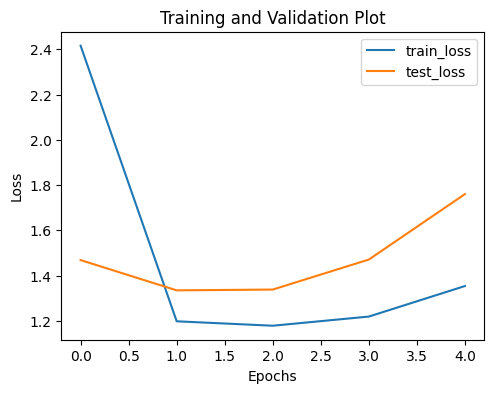

{'precision@10': np.float64(0.0006808510638297873), 'recall@10': np.float64(8.236859617392594e-05), 'ndcg@10': np.float64(0.000581037410815737), 'hit@10': np.float64(0.006808510638297872)}


In [ ]:
e_dataprep = DataPreparation(gts_train_df, gts_test_df, "userId", "movieId", "rating", implicit=False, threshold=3.0)
mf_model = MF(e_dataprep.n_users, e_dataprep.n_items, embedding_dim=30)
evaluator = Evaluator(e_dataprep)
e_training_configs = {
    "optimizer": torch.optim.Adam(mf_model.parameters(), lr=1e-1),
    "criterion": nn.MSELoss(),
    "batch_size": 4096,
    "num_epochs": 5
}
trainer = PyTorchTrainer(e_training_configs, device, evaluator)
mf_rec = MFRecommender(e_dataprep, mf_model, trainer, evaluator)
mf_rec.fit()
mf_rec_eval = evaluator.evaluate(mf_rec, ['precision', 'recall', 'ndcg', 'hit'], 10)
print(mf_rec_eval)

Epoch 1, Train Loss: 4.5163, Test Loss: 3.4197
Epoch 2, Train Loss: 3.2571, Test Loss: 3.1788
Epoch 3, Train Loss: 3.1249, Test Loss: 3.1339
Epoch 4, Train Loss: 3.0979, Test Loss: 3.1270
Epoch 5, Train Loss: 3.0936, Test Loss: 3.1254


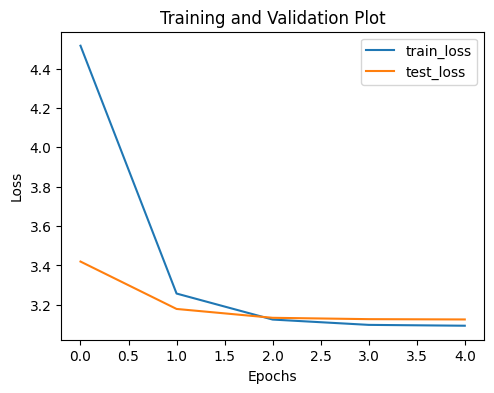

{'precision@10': np.float64(0.23063829787234041), 'recall@10': np.float64(0.04670121259502845), 'ndcg@10': np.float64(0.24673371092661822), 'hit@10': np.float64(0.6646808510638298)}


In [ ]:
e_dataprep = DataPreparation(gts_train_df, gts_test_df, "userId", "movieId", "rating", implicit=False, threshold=3.0)
mf_model = MF(e_dataprep.n_users, e_dataprep.n_items, embedding_dim=30)
evaluator = Evaluator(e_dataprep)
e_training_configs = {
    "optimizer": torch.optim.Adam(mf_model.parameters(), lr=1e-3, weight_decay=1e-2),
    "criterion": nn.MSELoss(),
    "batch_size": 512,
    "num_epochs": 5
}
trainer = PyTorchTrainer(e_training_configs, device, evaluator)
mf_rec = MFRecommender(e_dataprep, mf_model, trainer, evaluator)
mf_rec.fit()
mf_rec_eval = evaluator.evaluate(mf_rec, ['precision', 'recall', 'ndcg', 'hit'], 10)
print(mf_rec_eval)

Epoch 1, Train Loss: 5.9381, Test Loss: 5.2062
Epoch 2, Train Loss: 4.5244, Test Loss: 4.1084
Epoch 3, Train Loss: 3.4123, Test Loss: 3.2096
Epoch 4, Train Loss: 2.5447, Test Loss: 2.4929
Epoch 5, Train Loss: 1.9039, Test Loss: 1.9519


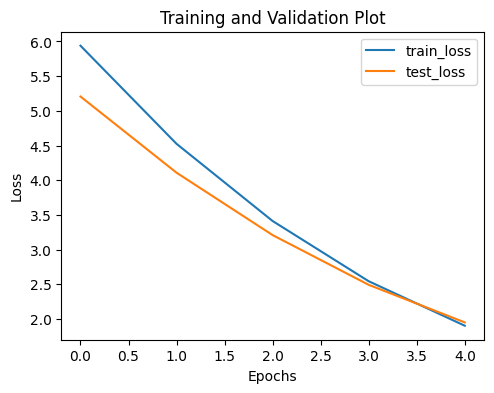

{'precision@10': np.float64(0.042893617021276594), 'recall@10': np.float64(0.006061205242581733), 'ndcg@10': np.float64(0.041645416676954004), 'hit@10': np.float64(0.2663829787234043)}


In [ ]:
e_dataprep = DataPreparation(gts_train_df, gts_test_df, "userId", "movieId", "rating", implicit=False, threshold=3.0)
mf_model = MF(e_dataprep.n_users, e_dataprep.n_items, embedding_dim=30)
evaluator = Evaluator(e_dataprep)
e_training_configs = {
    "optimizer": torch.optim.Adam(mf_model.parameters(), lr=1e-3, weight_decay=1e-4),
    "criterion": nn.MSELoss(),
    "batch_size": 512,
    "num_epochs": 5
}
trainer = PyTorchTrainer(e_training_configs, device, evaluator)
mf_rec = MFRecommender(e_dataprep, mf_model, trainer, evaluator)
mf_rec.fit()
mf_rec_eval = evaluator.evaluate(mf_rec, ['precision', 'recall', 'ndcg', 'hit'], 10)
print(mf_rec_eval)

Epoch 1, Train Loss: 5.9568, Test Loss: 5.2017
Epoch 2, Train Loss: 4.5403, Test Loss: 4.1067
Epoch 3, Train Loss: 3.4280, Test Loss: 3.2106
Epoch 4, Train Loss: 2.5616, Test Loss: 2.4960
Epoch 5, Train Loss: 1.9193, Test Loss: 1.9562
Epoch 6, Train Loss: 1.4811, Test Loss: 1.5825
Epoch 7, Train Loss: 1.2148, Test Loss: 1.3505
Epoch 8, Train Loss: 1.0750, Test Loss: 1.2243
Epoch 9, Train Loss: 1.0107, Test Loss: 1.1597
Epoch 10, Train Loss: 0.9803, Test Loss: 1.1270
Epoch 11, Train Loss: 0.9641, Test Loss: 1.1100
Epoch 12, Train Loss: 0.9550, Test Loss: 1.1029
Epoch 13, Train Loss: 0.9494, Test Loss: 1.0998
Epoch 14, Train Loss: 0.9456, Test Loss: 1.0959
Epoch 15, Train Loss: 0.9430, Test Loss: 1.0992
Epoch 16, Train Loss: 0.9410, Test Loss: 1.0969
Epoch 17, Train Loss: 0.9391, Test Loss: 1.0976
Epoch 18, Train Loss: 0.9382, Test Loss: 1.0950
Epoch 19, Train Loss: 0.9371, Test Loss: 1.0958
Epoch 20, Train Loss: 0.9364, Test Loss: 1.0937


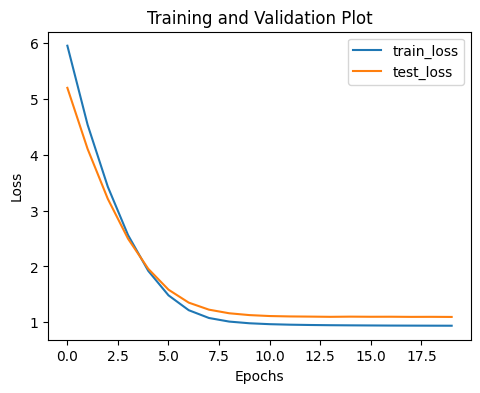

{'precision@10': np.float64(0.21268085106382978), 'recall@10': np.float64(0.050653451482489356), 'ndcg@10': np.float64(0.23084537606803537), 'hit@10': np.float64(0.6570212765957447)}


In [ ]:
e_dataprep = DataPreparation(gts_train_df, gts_test_df, "userId", "movieId", "rating", implicit=False, threshold=3.0)
mf_model = MF(e_dataprep.n_users, e_dataprep.n_items, embedding_dim=30)
evaluator = Evaluator(e_dataprep)
e_training_configs = {
    "optimizer": torch.optim.Adam(mf_model.parameters(), lr=1e-3, weight_decay=1e-4),
    "criterion": nn.MSELoss(),
    "batch_size": 512,
    "num_epochs": 20
}
trainer = PyTorchTrainer(e_training_configs, device, evaluator)
mf_rec = MFRecommender(e_dataprep, mf_model, trainer, evaluator)
mf_rec.fit()
mf_rec_eval = evaluator.evaluate(mf_rec, ['precision', 'recall', 'ndcg', 'hit'], 10)
print(mf_rec_eval)

Epoch 1, Train Loss: 1.5255, Test NDCG: 0.0298
Epoch 2, Train Loss: 0.6288, Test NDCG: 0.1066
Epoch 3, Train Loss: 0.5808, Test NDCG: 0.2371
Epoch 4, Train Loss: 0.5750, Test NDCG: 0.2395
Epoch 5, Train Loss: 0.5743, Test NDCG: 0.2422
Epoch 6, Train Loss: 0.5744, Test NDCG: 0.2408
Epoch 7, Train Loss: 0.5742, Test NDCG: 0.2412
Epoch 8, Train Loss: 0.5742, Test NDCG: 0.2410
Epoch 9, Train Loss: 0.5742, Test NDCG: 0.2400
Epoch 10, Train Loss: 0.5742, Test NDCG: 0.2412


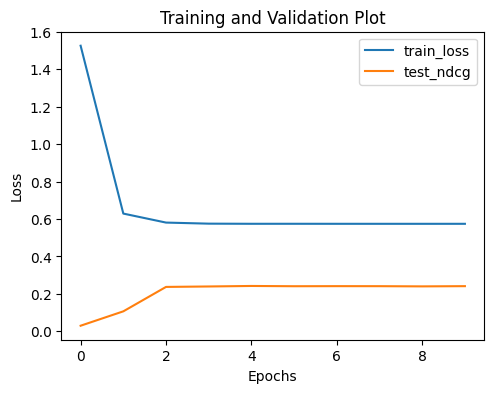

In [ ]:
i_dataprep = DataPreparation(gts_train_df, gts_test_df, "userId", "movieId", "rating", implicit=True, threshold=3.0)
mf_model_i = MF(i_dataprep.n_users, i_dataprep.n_items, embedding_dim=64)
evaluator_i = Evaluator(i_dataprep)
i_training_configs = {
    "optimizer": torch.optim.Adam(mf_model_i.parameters(), lr=1e-3, weight_decay=1e-3),
    "criterion": BPRLoss(),
    "batch_size": 512,
    "num_epochs": 10
}
trainer = PyTorchTrainer(i_training_configs, device, evaluator_i)
mf_rec_i = MFRecommender(i_dataprep, mf_model_i, trainer, evaluator_i)
mf_rec_i.fit()
mf_rec_i_eval = evaluator.evaluate(mf_rec_i, ['precision', 'recall', 'ndcg', 'hit'], 10)

In [ ]:
mf_rec_i_eval

{'precision@10': np.float64(0.22697872340425534),
 'recall@10': np.float64(0.04523161425672395),
 'ndcg@10': np.float64(0.24117279639908099),
 'hit@10': np.float64(0.6570212765957447)}

Epoch 1, Train Loss: 3.3672, Test NDCG: 0.0401
Epoch 2, Train Loss: 1.7239, Test NDCG: 0.0885
Epoch 3, Train Loss: 0.8196, Test NDCG: 0.1532
Epoch 4, Train Loss: 0.4718, Test NDCG: 0.2068
Epoch 5, Train Loss: 0.4028, Test NDCG: 0.2373
Epoch 6, Train Loss: 0.3982, Test NDCG: 0.2412
Epoch 7, Train Loss: 0.3989, Test NDCG: 0.2418
Epoch 8, Train Loss: 0.3983, Test NDCG: 0.2420
Epoch 9, Train Loss: 0.3984, Test NDCG: 0.2410
Epoch 10, Train Loss: 0.3973, Test NDCG: 0.2410


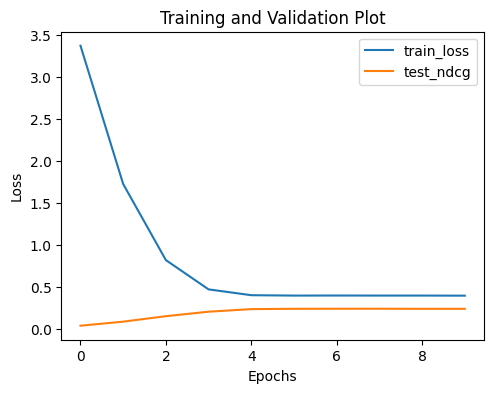

{'precision@10': np.float64(0.22621276595744677), 'recall@10': np.float64(0.04434874918557547), 'ndcg@10': np.float64(0.24095073181239499), 'hit@10': np.float64(0.6604255319148936)}


In [ ]:
i_dataprep = DataPreparation(gts_train_df, gts_test_df, "userId", "movieId", "rating", implicit=True, threshold=3.0)
mf_model_i = MF(i_dataprep.n_users, i_dataprep.n_items, embedding_dim=64)
evaluator_i = Evaluator(i_dataprep)
i_training_configs = {
    "optimizer": torch.optim.Adam(mf_model_i.parameters(), lr=1e-3, weight_decay=1e-4),
    "criterion": BPRLoss(),
    "batch_size": 512,
    "num_epochs": 10
}
trainer = PyTorchTrainer(i_training_configs, device, evaluator_i)
mf_rec_i = MFRecommender(i_dataprep, mf_model_i, trainer, evaluator_i)
mf_rec_i.fit()
mf_rec_i_eval = evaluator.evaluate(mf_rec_i, ['precision', 'recall', 'ndcg', 'hit'], 10)
print(mf_rec_i_eval)

Epoch 1, Train Loss: 2.0670, Test NDCG: 0.0337
Epoch 2, Train Loss: 0.6443, Test NDCG: 0.0958
Epoch 3, Train Loss: 0.5794, Test NDCG: 0.2384
Epoch 4, Train Loss: 0.5748, Test NDCG: 0.2419
Epoch 5, Train Loss: 0.5743, Test NDCG: 0.2408
Epoch 6, Train Loss: 0.5741, Test NDCG: 0.2407
Epoch 7, Train Loss: 0.5742, Test NDCG: 0.2426
Epoch 8, Train Loss: 0.5741, Test NDCG: 0.2413
Epoch 9, Train Loss: 0.5745, Test NDCG: 0.2423
Epoch 10, Train Loss: 0.5744, Test NDCG: 0.2414


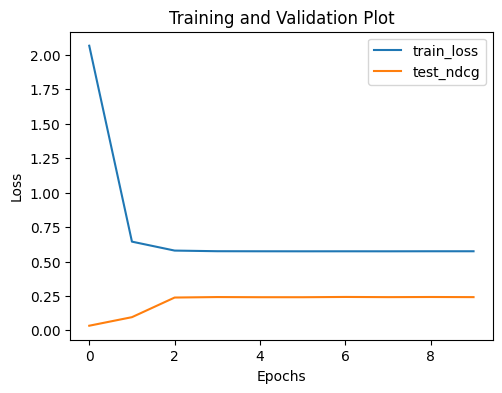

{'precision@10': np.float64(0.22791489361702127), 'recall@10': np.float64(0.045237644623255566), 'ndcg@10': np.float64(0.24137830944628494), 'hit@10': np.float64(0.6578723404255319)}


In [ ]:
i_dataprep = DataPreparation(gts_train_df, gts_test_df, "userId", "movieId", "rating", implicit=True, threshold=3.0)
mf_model_i = MF(i_dataprep.n_users, i_dataprep.n_items, embedding_dim=64)
evaluator_i = Evaluator(i_dataprep)
i_training_configs = {
    "optimizer": torch.optim.Adam(mf_model_i.parameters(), lr=1e-3, weight_decay=1e-3),
    "criterion": BPRLoss(),
    "batch_size": 512,
    "num_epochs": 10
}
trainer = PyTorchTrainer(i_training_configs, device, evaluator_i)
mf_rec_i = MFRecommender(i_dataprep, mf_model_i, trainer, evaluator_i)
mf_rec_i.fit()
mf_rec_i_eval = evaluator.evaluate(mf_rec_i, ['precision', 'recall', 'ndcg', 'hit'], 10)
print(mf_rec_i_eval)

In [ ]:
i_dataprep = DataPreparation(gts_train_df, gts_test_df, "userId", "movieId", "rating", implicit=True, threshold=3.0)
knn_model_i = ItemKNN(10, 10, i_dataprep)
evaluator_i = Evaluator(i_dataprep)
knn_model_i.fit()
knn_model_i_eval = evaluator.evaluate(knn_model_i, ['precision', 'recall', 'ndcg', 'hit'], 10)
print(knn_model_i_eval)

{'precision@10': np.float64(0.23012765957446807), 'recall@10': np.float64(0.04457405603799276), 'ndcg@10': np.float64(0.2456901791526377), 'hit@10': np.float64(0.6331914893617021)}


In [ ]:
i_dataprep = DataPreparation(gts_train_df, gts_test_df, "userId", "movieId", "rating", implicit=True, threshold=3.0)
knn_model_i = ItemKNN(10, 0, i_dataprep)
evaluator_i = Evaluator(i_dataprep)
knn_model_i.fit()
knn_model_i_eval = evaluator.evaluate(knn_model_i, ['precision', 'recall', 'ndcg', 'hit'], 10)
print(knn_model_i_eval)

{'precision@10': np.float64(0.2285957446808511), 'recall@10': np.float64(0.04428413748688034), 'ndcg@10': np.float64(0.2439741017447561), 'hit@10': np.float64(0.6323404255319149)}


## 3.F. Item-POP

# 5. Defining Pipeline

# 6. Experimentations

## 6.A. How do different splitting strategies affect explicit MF's model performance?

## 6.B. Does implicit MF with pairwise loss performs better than explicit MF?

## 6.C. How does NCF perform compared to previous models and baselines?

## 6.D. How does Sequence-Aware RecSys perform compared to previous models and baselines?